In [449]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error,root_mean_squared_error,mean_absolute_error
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F

In [450]:
df=pd.read_csv('headlines_with_prices.csv')
df = df.loc[:, ~df.columns.str.contains("^Unnamed")]
df.head()

,date,ticker,sentiment,close
0,2009-07-27,MRK,-1,16.760765
1,2009-07-28,MRK,0,16.352232
2,2009-07-29,MRK,0,16.270533
3,2009-07-30,MRK,0,16.308653
4,2009-07-31,MRK,0,16.346785


In [451]:
df['date']=pd.to_datetime(df['date'])
df.set_index('date',inplace=True)
df=df.asfreq('B')
df

,ticker,sentiment,close
date,,,
2009-07-27,MRK,-1.0,16.760765
2009-07-28,MRK,0.0,16.352232
2009-07-29,MRK,0.0,16.270533
2009-07-30,MRK,0.0,16.308653
2009-07-31,MRK,0.0,16.346785
...,...,...,...
2020-06-05,MRK,0.0,65.446350
2020-06-08,MRK,0.0,65.955528
2020-06-09,MRK,0.0,65.446350


In [409]:
df['close'] = df['close'].ffill()
df['sentiment'] = df['sentiment'].fillna(0)

In [432]:
scaler=MinMaxScaler()
df['close_scaled']=scaler.fit_transform(df['close'].values.reshape(-1,1))

In [433]:
WINDOW = 6
features = df[["close_scaled", "sentiment"]].values.astype(np.float32)
def create_sequences(data, window):
    X, y = [], []
    for i in range(window, len(data)):
        X.append(data[i-window:i])
        y.append(data[i, 0])   # target = close_scaled
    return np.array(X), np.array(y)
X, y = create_sequences(features, WINDOW)

In [415]:
X_train=torch.tensor(X[0:int(0.7*len(X))],dtype=torch.float32)
y_train=torch.tensor(y[0:int(0.7*len(y))],dtype=torch.float32)
X_test=torch.tensor(X[int(0.7*len(X)):],dtype=torch.float32)
y_test=torch.tensor(y[int(0.7*len(y)):],dtype=torch.float32)


In [416]:
y_train = torch.tensor(y_train).unsqueeze(1)
y_test  = torch.tensor(y_test).unsqueeze(1)

/var/folders/x9/0xsgqm2n559290vsdxtfl2dh0000gn/T/ipykernel_20229/195427950.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train).unsqueeze(1)
/var/folders/x9/0xsgqm2n559290vsdxtfl2dh0000gn/T/ipykernel_20229/195427950.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test  = torch.tensor(y_test).unsqueeze(1)


In [417]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

(torch.Size([1983, 6, 2]),
 torch.Size([850, 6, 2]),
 torch.Size([1983, 1]),
 torch.Size([850, 1]))

In [418]:
class LSTMModel(nn.Module):

  def __init__(self,input_dim,hidden_dim,layer_dim,output_dim):
    super().__init__()
    self.hidden_dim=hidden_dim # hidden dimension
    self.layer_dim=layer_dim # No of Layers
    self.lstm=nn.LSTM(input_size=input_dim,hidden_size=hidden_dim,num_layers=layer_dim,batch_first=True) # created a lstm model.
    self.fc=nn.Linear(hidden_dim,output_dim) # created a linear layer between then hidden state to output.

  def forward(self,x):
    batch_size=x.size(0)

    h0=torch.zeros(self.layer_dim,batch_size,self.hidden_dim).to(x.device) # h0,c0 and x must be on the same device.
    c0=torch.zeros(self.layer_dim,batch_size,self.hidden_dim).to(x.device)

    out,_=self.lstm(x,(h0,c0))
    out=out[:,-1,:]
    out=self.fc(out)

    return out


In [441]:
model=LSTMModel(input_dim=2,hidden_dim=30,layer_dim=2,output_dim=1)

In [442]:
criterion=nn.MSELoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.001)

In [443]:
num_epochs = 190
losses=[]

for i in range(num_epochs):
  model.train()
  y_train_pred=model(X_train)
  loss=criterion(y_train_pred,y_train)
  losses.append(loss.item())

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  if (i+1)%10==0 or i==0 :
    print(f"Epoch : {i+1}   ,   Loss  :  {loss}")


Epoch : 1   ,   Loss  :  0.05613076686859131
Epoch : 10   ,   Loss  :  0.027098270133137703
Epoch : 20   ,   Loss  :  0.02420322597026825
Epoch : 30   ,   Loss  :  0.021475283429026604
Epoch : 40   ,   Loss  :  0.020272428169846535
Epoch : 50   ,   Loss  :  0.017576690763235092
Epoch : 60   ,   Loss  :  0.013328680768609047
Epoch : 70   ,   Loss  :  0.006424835417419672
Epoch : 80   ,   Loss  :  0.0005990943172946572
Epoch : 90   ,   Loss  :  0.0012449932983145118
Epoch : 100   ,   Loss  :  0.00047087945858947933
Epoch : 110   ,   Loss  :  0.000505553325638175
Epoch : 120   ,   Loss  :  0.00037834906834177673
Epoch : 130   ,   Loss  :  0.00034561389475129545
Epoch : 140   ,   Loss  :  0.0003062151372432709
Epoch : 150   ,   Loss  :  0.0002743265649769455
Epoch : 160   ,   Loss  :  0.00024869790649972856
Epoch : 170   ,   Loss  :  0.00022574888134840876
Epoch : 180   ,   Loss  :  0.00020654825493693352
Epoch : 190   ,   Loss  :  0.0001902852818602696


In [444]:
model.eval()

with torch.no_grad():
  y_test_pred=model(X_test)
  test_loss=criterion(y_test_pred,y_test)

print(f"Test loss for model : {test_loss}")


Test loss for model : 0.0008502029231749475


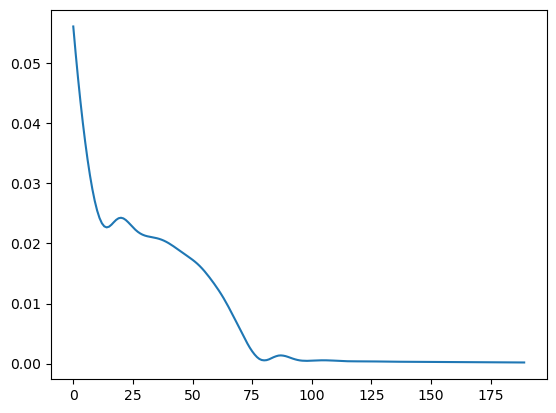

In [445]:
plt.plot(losses)
plt.show()

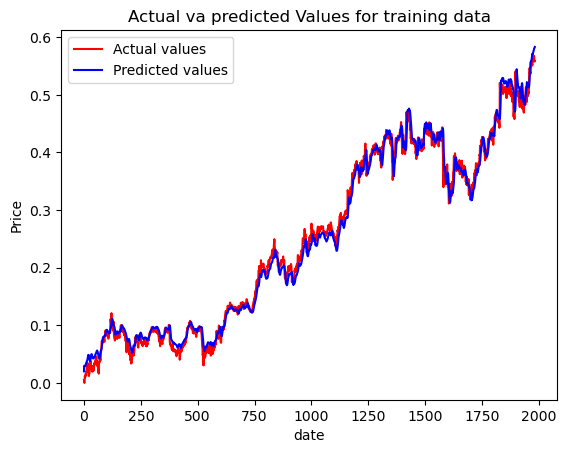

In [446]:
plt.plot(y_train,color='red',label='Actual values')
plt.plot(y_train_pred.detach().numpy(),color='blue',label='Predicted values')
plt.legend()
plt.xlabel('date')
plt.ylabel('Price')
plt.title('Actual va predicted Values for training data')
plt.show()

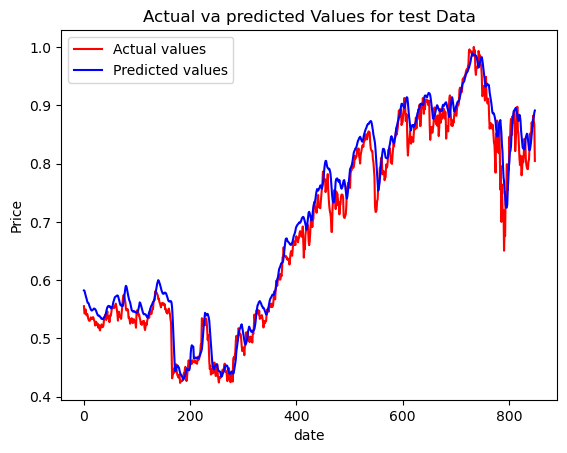

In [447]:
plt.plot(y_test,color='red',label='Actual values')
plt.plot(y_test_pred.detach().numpy(),color='blue',label='Predicted values')
plt.legend()
plt.xlabel('date')
plt.ylabel('Price')
plt.title('Actual va predicted Values for test Data')
plt.show()

In [448]:
print(f"Te mean Absolute Error for LSTM is {mean_absolute_error(y_test,y_test_pred.detach().numpy())}")
print(f"The Mean Squared Error for LSTM is {mean_squared_error(y_test,y_test_pred.detach().numpy())}")
print(f"The Root Mean Squared Error for LSTM is {root_mean_squared_error(y_test,y_test_pred.detach().numpy())}")

Te mean Absolute Error for LSTM is 0.02173842117190361
The Mean Squared Error for LSTM is 0.0008502029231749475
The Root Mean Squared Error for LSTM is 0.02915824018418789
